# ___

# [ Machine Learning in Geosciences ]

**Department of Applied Geoinformatics and Carthography, Charles University** 

*Lukas Brodsky lukas.brodsky@natur.cuni.cz*

    
___



# Exercise: End-to-End Machine Learning Project!

Develop the following steps for the given data set and described problem. 
1. Task description 
2. Exploratory Data Analysis
3. Data preparation 
4. Select and train model 
5. Model fine-tuning 
6. Results interpretation

___    

# 1/ The Problem 

**Problem Statement** 
The goal is to develop a predictive model for housing prices in California using census data. The model should accurately estimate the median housing price for any given district based on relevant socioeconomic and geographical factors.

**Objective:**
The primary objective is to build a machine learning model that can generalize well across different regions in California. The model should leverage available census data to capture key patterns influencing housing prices, such as location, population density, income levels, and housing characteristics.

**Data Description**
The dataset consists of housing-related and demographic attributes for various districts in California, as recorded in the U.S. census. Key features include:

- Median income of district residents
- Household population and housing unit counts
- Geographical coordinates (latitude, longitude)
- Proximity to the ocean (e.g., inland vs. coastal regions)
- Median house age and total rooms/bedrooms per household
- Median house value (target variable)

**Challenges:**
- Feature Engineering: Handling missing values, categorical encoding (e.g., proximity to ocean), and outlier detection.
- Non-linearity & Feature Interactions: The relationship between predictors and housing prices may be complex and require non-linear modeling approaches.
- Geospatial Variability: Housing prices vary significantly based on location, requiring spatial awareness in the model.
- Data Imbalance: Certain high-value or low-value districts may be underrepresented, leading to biased predictions.
- Generalization: Ensuring the model performs well on new, unseen districts rather than overfitting to training data.

**Strengths:**
- Rich Dataset: The dataset contains diverse attributes that provide valuable insights into housing price drivers.
- Geospatial Information: Latitude and longitude enable the inclusion of spatial dependencies.
- Potential for Feature Engineering: Additional features like population density or room-to-household ratios can improve predictive performance.

**Performance Measures:** 
- **Mean Absolute Error (MAE)**: Measures the average absolute difference between actual and predicted prices, providing an intuitive interpretation.
- Root Mean Squared Error (RMSE): Penalizes larger errors more than MAE, useful for emphasizing significant prediction mistakes.
- R² Score (Coefficient of Determination): Evaluates how well the model explains the variance in housing prices.
- Mean Absolute Percentage Error (MAPE): Expresses prediction error as a percentage, making it useful for relative performance comparisons.


**Assumptions of the problem:** 
* There exist some (most likely non-linear) relationship between input features (X) and the output target  variable (y); 
* the output target is a continuous variable, hence we employ regression type of model; 
* There are multiple features, hence multivariate regression; 
* There is no continuous flow of data -> batch learning;

**The expected result:** 
The developed model shall predict housing prices based set of characteristics (fetures) with error < 20 %. 


### Setup environment

In [113]:
import os
import numpy as np
import pandas as pd
import seaborn as sns 
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt 

# Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor

# to make this notebook's output stable across runs
np.random.seed(42)
# To plot 'pretty' figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

# 2. Exploratory Data Analysis (EDA) 


- Load the data 
- Take a quick look at the data structure!
- Visualize the data to gain insights 
- Look for correlations

In [2]:
# Inport data 
data_path = './data'


# function to read the csv file 
def load_housing_data(housing_path=data_path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
# load data 
housing = load_housing_data()

### What is the structure of the dataset?

In [4]:
# check header and some values 
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# evaluate the values 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Some missing 'total_bedrooms'

In [6]:
# Evaluate statistics of the features 
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
# features 
housing_columns = list(housing.columns)
housing_columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

###  Is the dataset balanced?

In [23]:
housing_rval = housing.drop('ocean_proximity', axis=1)
housing_rval.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

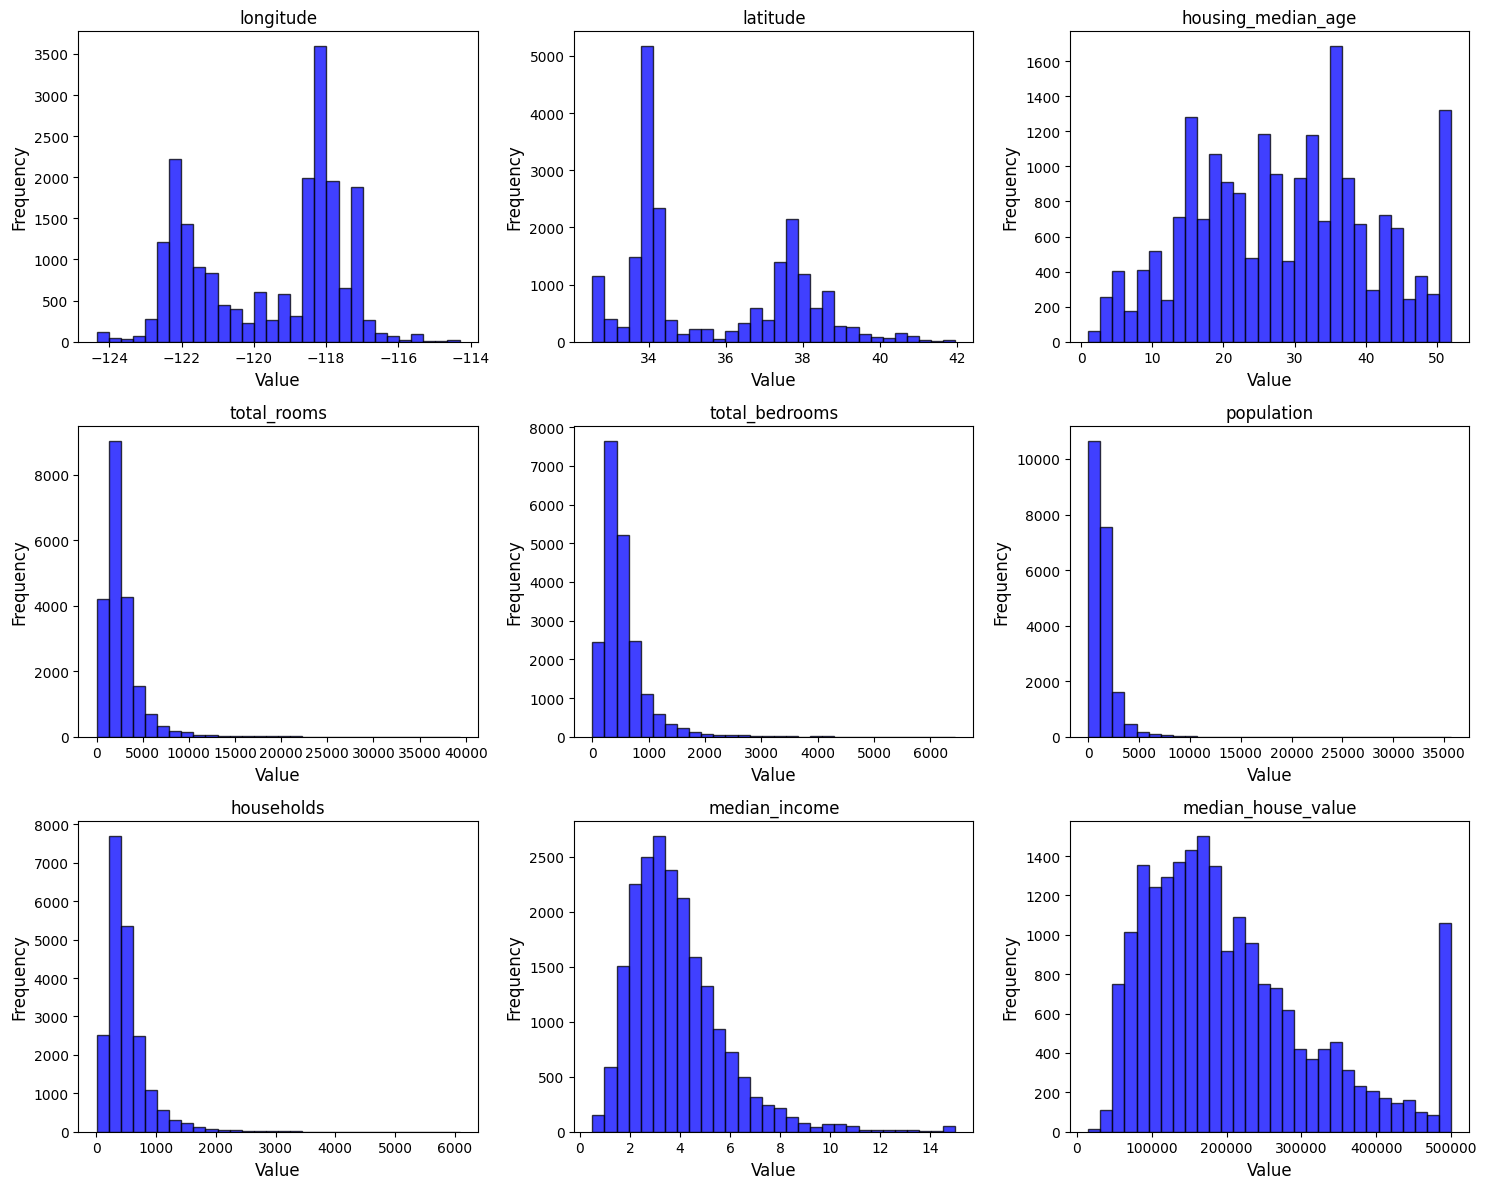

In [24]:
# Plot histograms for each feature
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(housing_rval.columns):
    axes[i].hist(housing_rval[col], bins=30, alpha=0.75, color='blue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Visualize the data to gain insights

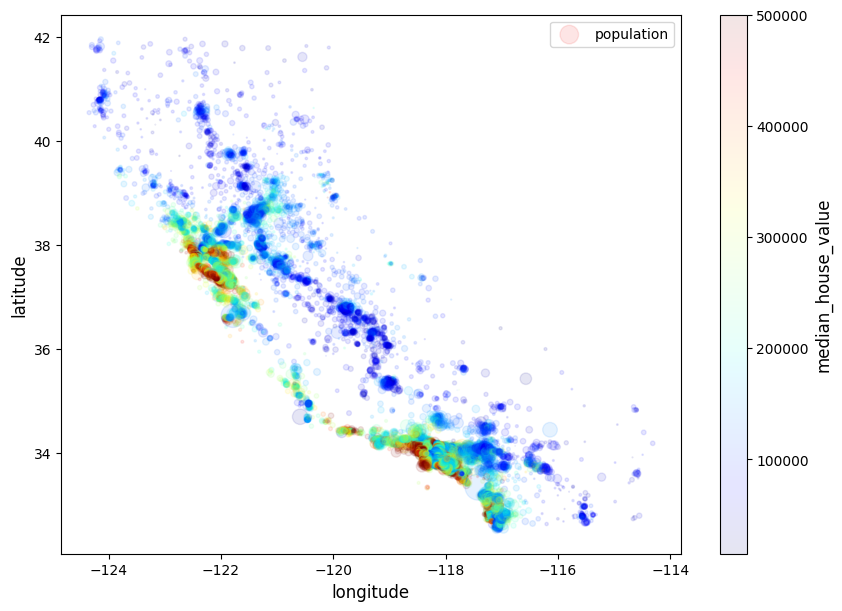

In [27]:
# plot housing data (spatial plot )
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,
             c="median_house_value",
             s=housing["population"]/100, label="population", figsize=(10,7),
             cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

### Looking for Correlations

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


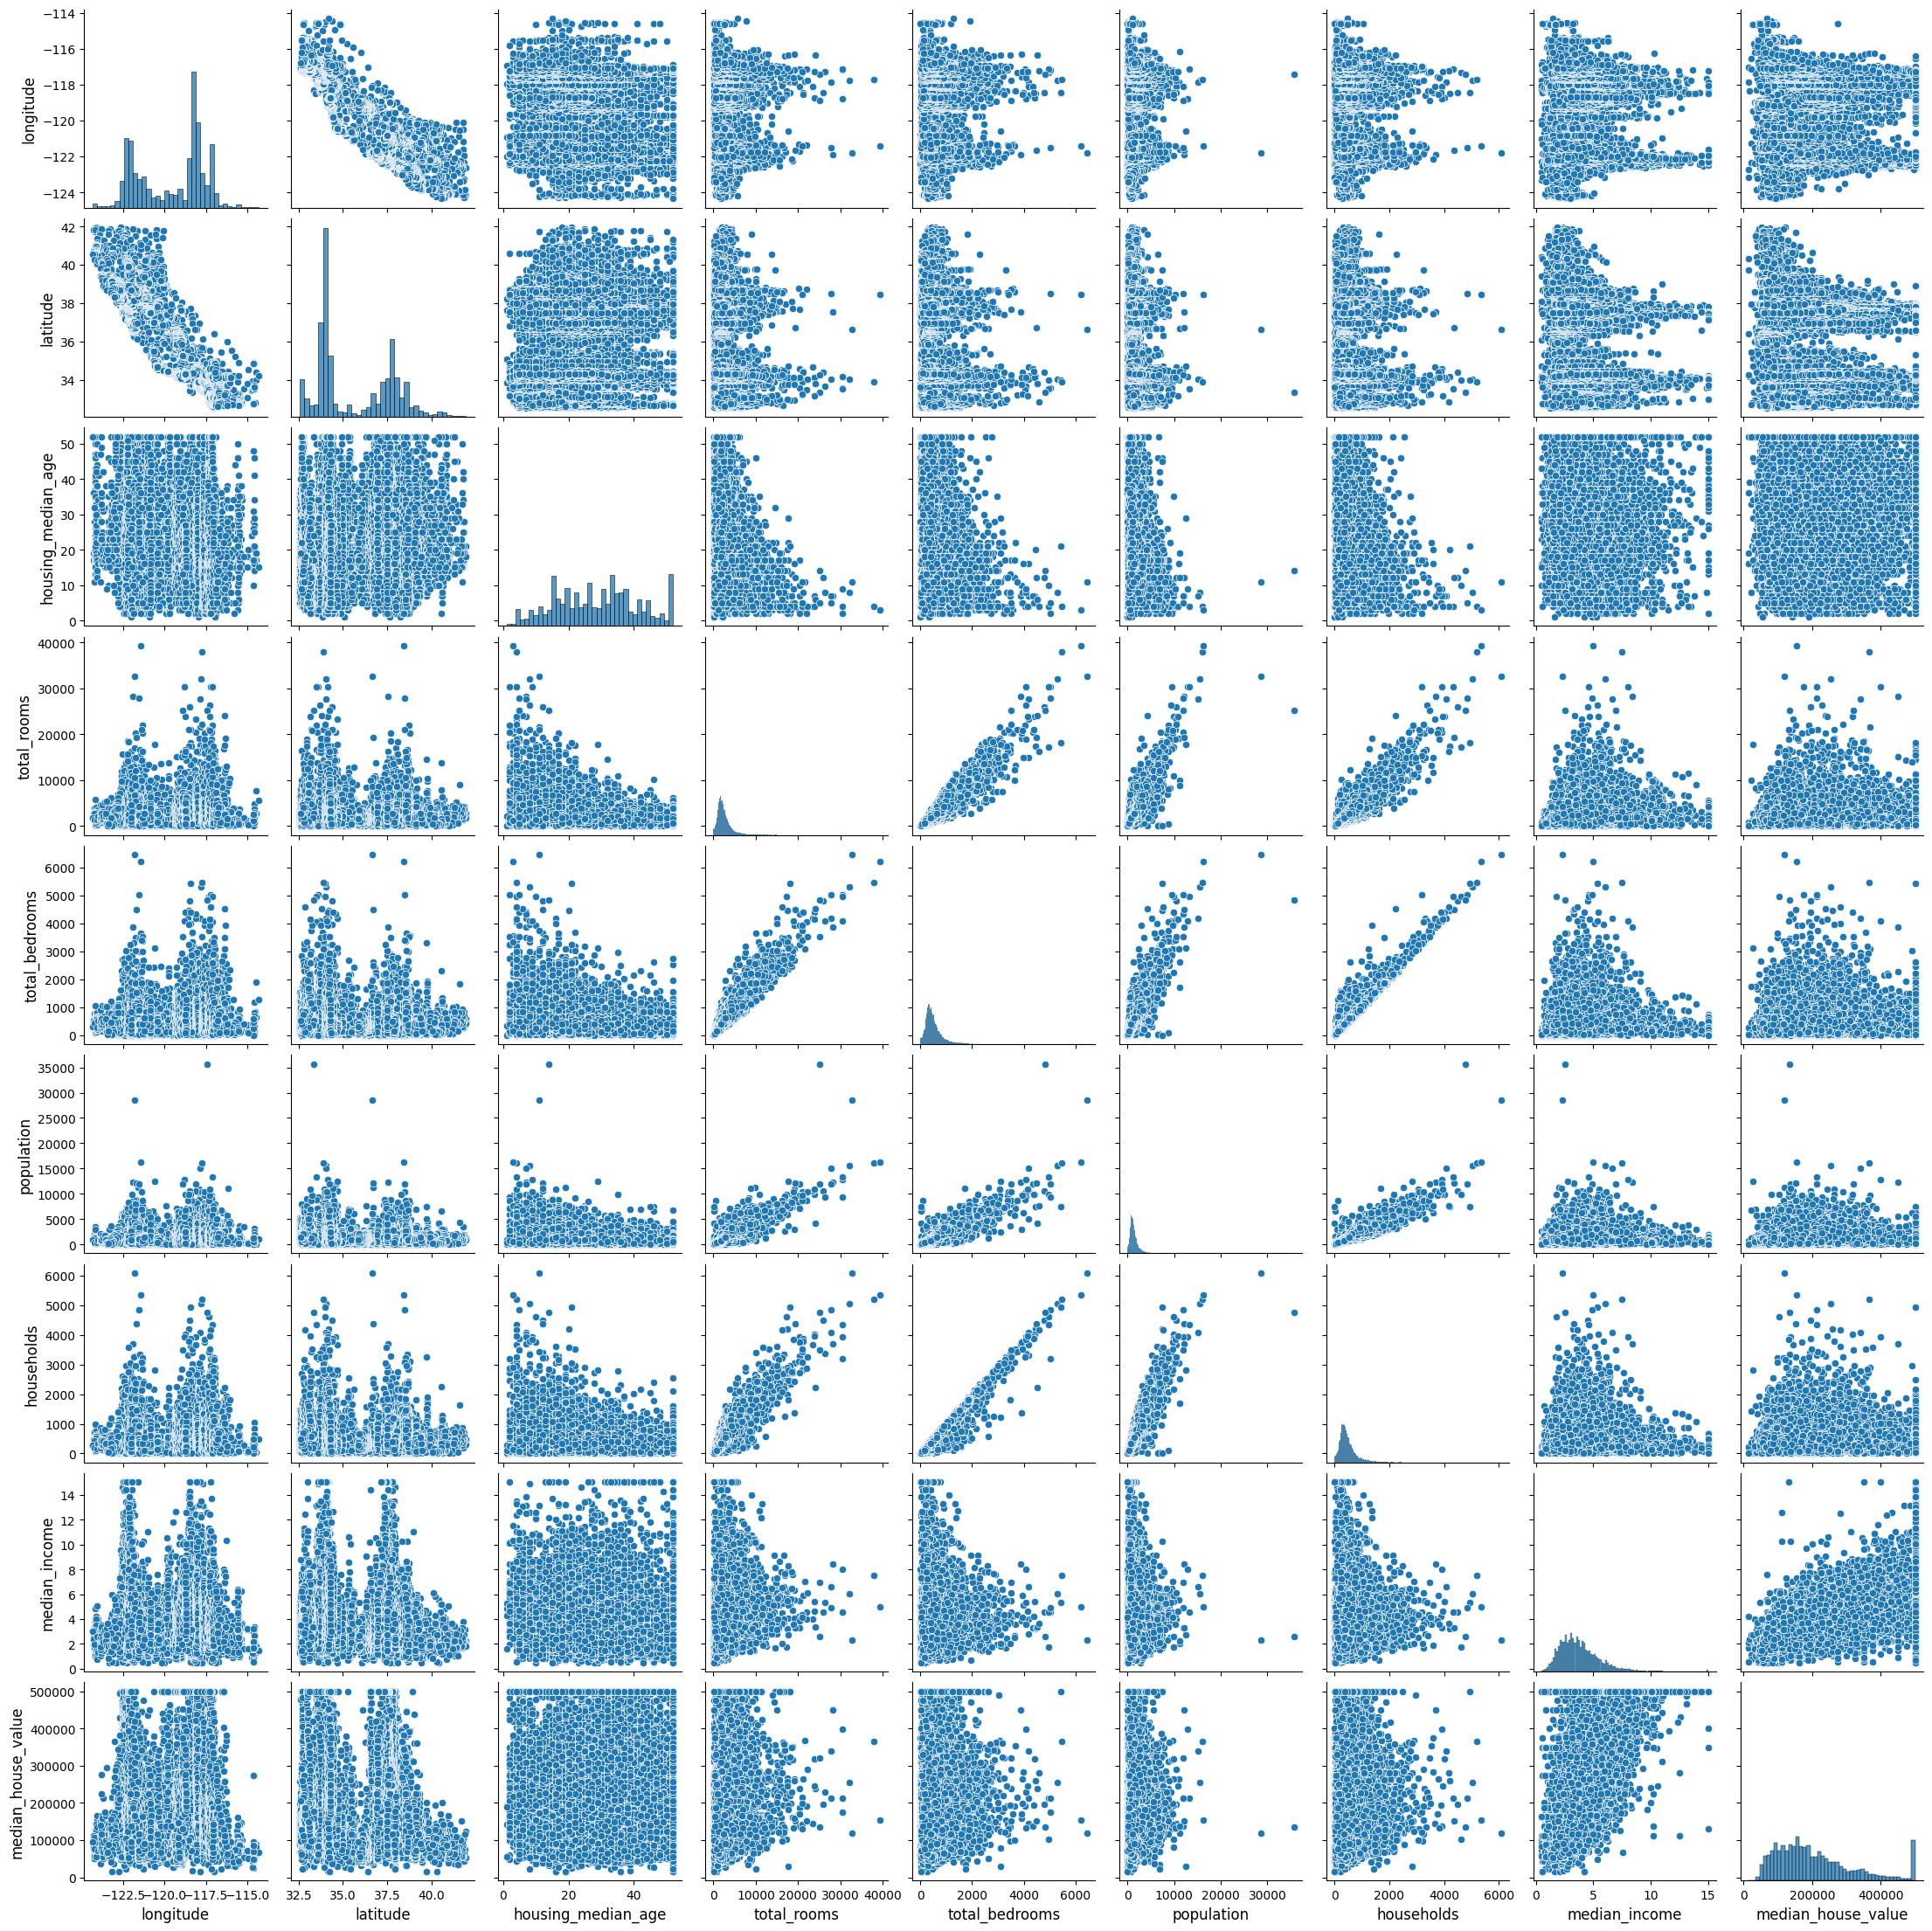

In [17]:
sns.pairplot(housing_rval)

In [13]:
# Prepare correlation data 
# corr_matrix = housing_rval.corr()

In [18]:
# corr_matrix["median_house_value"].sort_values(ascending=False)

In [19]:
# cross-scatterplot for selected features 
# attributes = ["median_house_value", "median_income", "total_rooms",
#               "housing_median_age"]
# scatter_matrix(housing[attributes], figsize=(7, 5), alpha=0.3)
# save_fig("scatter_matrix_plot")

In [20]:
# housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
# plt.axis([0, 16, 0, 550000])
# save_fig("income_vs_house_value_scatterplot")

#### Experiment with Attributes 
.. later on in data preparation. 

# 3/ Prepare the data for Machine Learning algorithms

- New fetures (rooms_per_household, bedrooms_per_room, population_per_household) 
- Fill no-data values or drop incomplete records
- Harmonize numerical data - Feature Endcoding
- Split Data set into Training and Test Sets (Try Stratified sampling - Is there a balnce?) 


In [28]:
housing.shape

(20640, 10)

### New fetures

In [29]:
# add some more features (relative indicators) 
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [30]:
housing_columns = housing.columns
housing_columns = list(housing_columns)

In [31]:
housing.shape

(20640, 13)

In [32]:
# Append new feature names to the list of columns 
housing_columns.append('rooms_per_household')
housing_columns.append('bedrooms_per_room')
housing_columns.append('population_per_household')
housing_columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household']

### Fill no-data values or drop incomplete records

In [34]:
# Which records have NaN record?
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,5.761468,NaN,2.614679
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,3.830116,NaN,2.826255
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,4.048704,NaN,2.938727
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,6.102740,NaN,2.630137
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY,4.633540,NaN,2.403727


In [35]:
sample_incomplete_rows.shape

(5, 13)

### Drop NaN records 

In [36]:
# Option 1: .dropna()
# sample_incomplete_rows.dropna(subset=["total_bedrooms"])    

In [37]:
# Option 2: .drop()
# sample_incomplete_rows.drop("total_bedrooms", axis=1)       

### Fill-in meadian value 

In [38]:
# Option 3: fill-in meadian value 
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) 
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
290,-122.16,37.77,47.0,1256.0,435.0,570.0,218.0,4.3750,161900.0,NEAR BAY,5.761468,NaN,2.614679
341,-122.17,37.75,38.0,992.0,435.0,732.0,259.0,1.6196,85100.0,NEAR BAY,3.830116,NaN,2.826255
538,-122.28,37.78,29.0,5154.0,435.0,3741.0,1273.0,2.5762,173400.0,NEAR BAY,4.048704,NaN,2.938727
563,-122.24,37.75,45.0,891.0,435.0,384.0,146.0,4.9489,247100.0,NEAR BAY,6.102740,NaN,2.630137
696,-122.10,37.69,41.0,746.0,435.0,387.0,161.0,3.9063,178400.0,NEAR BAY,4.633540,NaN,2.403727


### Sklearn Imputer

In [39]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

In [40]:
# Remove the text attribute because median can only be calculated on numerical attributes:
housing_num = housing.drop('ocean_proximity', axis=1)
# housing_num

In [41]:
# fit the imputer instance to the training data using the fit() method
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [42]:
imputer.statistics_

array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        1.79700000e+05,  5.22912879e+00,  2.03162434e-01,  2.81811565e+00])

In [43]:
# Check that this is the same as manually computing the median of each attribute:
housing_num.median().values

array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        1.79700000e+05,  5.22912879e+00,  2.03162434e-01,  2.81811565e+00])

In [44]:
# Now we can use this “trained” imputer to transform the training set 
# by replacing missing values by the learned medians

housing_num_imp = imputer.transform(housing_num)

# Numpy array containing the transformed features
print(type(housing_num_imp))

<class 'numpy.ndarray'>


In [45]:
# put it back into a Pandas DataFrame
housing_num_tr = pd.DataFrame(housing_num_imp, columns=housing_num.columns,
                          index=housing.index)

In [46]:
# check the imputation 
housing_num_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
290,-122.16,37.77,47.0,1256.0,435.0,570.0,218.0,4.3750,161900.0,5.761468,0.203162,2.614679
341,-122.17,37.75,38.0,992.0,435.0,732.0,259.0,1.6196,85100.0,3.830116,0.203162,2.826255
538,-122.28,37.78,29.0,5154.0,435.0,3741.0,1273.0,2.5762,173400.0,4.048704,0.203162,2.938727
563,-122.24,37.75,45.0,891.0,435.0,384.0,146.0,4.9489,247100.0,6.102740,0.203162,2.630137
696,-122.10,37.69,41.0,746.0,435.0,387.0,161.0,3.9063,178400.0,4.633540,0.203162,2.403727


In [47]:
imputer.strategy

'median'

In [48]:
housing_num_tr.shape

(20640, 12)

In [ ]:
# put it back into a Pandas DataFrame
# housing_num_scaled = pd.DataFrame(housing_num_scaled, columns=housing_num.columns,
#                           index=housing.index)

In [ ]:
# housing_num_scaled.head()

In [ ]:
# housing_num_scaled.shape

### Harmonize numerical data - Feature Endcoding 

Transform cathegorical text feature(s) into numerical. 

In [49]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn > 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

In [50]:
housing["ocean_proximity"]

0        NEAR BAY
1        NEAR BAY
2        NEAR BAY
3        NEAR BAY
4        NEAR BAY
           ...   
20635      INLAND
20636      INLAND
20637      INLAND
20638      INLAND
20639      INLAND
Name: ocean_proximity, Length: 20640, dtype: object

In [51]:
housing["ocean_proximity"].shape 

(20640,)

In [52]:
# encoder = OneHotEncoder()
encoder= OneHotEncoder(sparse_output=False).set_output(transform="pandas")
encoder.fit(housing[["ocean_proximity"]])
ocean_proximity_num = encoder.transform(housing[["ocean_proximity"]])

In [53]:
type(ocean_proximity_num)

pandas.core.frame.DataFrame

In [54]:
ocean_proximity_num.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [55]:
housing_num_tr.shape

(20640, 12)

In [56]:
ocean_proximity_num.shape

(20640, 5)

In [57]:
# Merge the two DataFrames
housing_num_enc_merged = pd.concat([housing_num_tr, ocean_proximity_num], axis=1)
housing_num_enc_merged.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,2.109842,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,2.802260,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,2.547945,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,2.181467,0.0,0.0,0.0,1.0,0.0


In [58]:
housing_num_enc_merged.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household', 'bedrooms_per_room',
       'population_per_household', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [59]:
housing_num_enc_merged.shape

(20640, 17)

### Split Data set into Training and Test Sets

Options: 

    * random sampling (introducing a significant sampling bias); 
    * stratified sampling (to ensure that split sample is representative of the whole populatio); 
    

### Numpy random solution

In [60]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [61]:
train_set, test_set = split_train_test(housing_num_enc_merged, 0.5)
print(f'Train set size: {len(train_set)}, Test set size: {len(test_set)}')

Train set size: 10320, Test set size: 10320


### Scikit learn split functions

To make repeated experiments set `random_state` to some constatnt!

In [62]:
# split 
train_set, test_set = train_test_split(housing_num_enc_merged, test_size=0.5, random_state=42)

In [63]:
print(f'Train set size: {len(train_set)}, Test set size: {len(test_set)}')

Train set size: 10320, Test set size: 10320


### Stratified sampling


<Axes: >

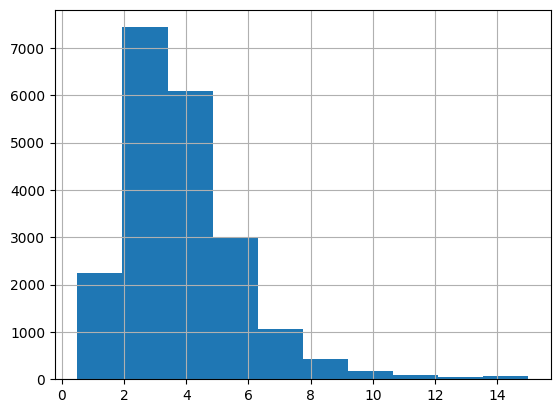

In [64]:
# check histogram 
housing_num_enc_merged["median_income"].hist()

In [65]:
# cut the histogram into bins 
housing_num_enc_merged["income_cat"] = pd.cut(housing_num_enc_merged["median_income"],
                               bins=[0.0, 2.0, 3.0, 4.0,  np.inf],
                                labels=[1, 2, 3, 4])

In [66]:
# chaeck for NaNs 
housing_num_enc_merged["income_cat"].isnull().any()

False

In [67]:
# housing_num_enc_merged["income_cat"]
# housing_num_enc_merged[housing_num_enc_merged["income_cat"].isnull().any(axis=1)].head()
# housing_num_enc_merged[housing_num_enc_merged["income_cat"].isnull()]['median_income'].hist()

<Axes: >

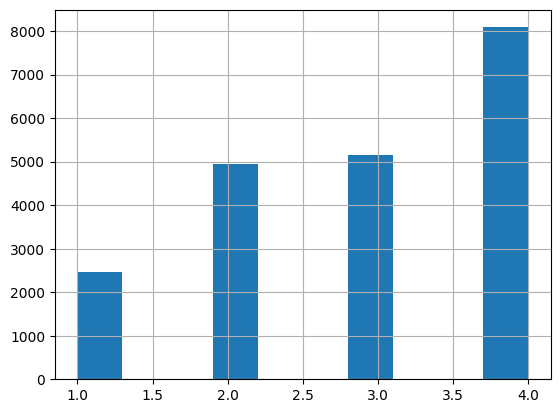

In [68]:
# check distribution in the bins
housing_num_enc_merged["income_cat"].hist()

In [69]:
# housing_num_enc_merged["income_cat"] 

In [70]:
# Do stratified sampling based on the income category!
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index, test_index in sss.split(housing_num_enc_merged, housing_num_enc_merged["income_cat"]):
    strat_train_set = housing_num_enc_merged.loc[train_index]
    strat_test_set = housing_num_enc_merged.loc[test_index]

In [71]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,income_cat
5838,-118.36,34.20,14.0,1878.0,614.0,1874.0,559.0,2.5267,231800.0,3.359571,0.326944,3.352415,1.0,0.0,0.0,0.0,0.0,2
1985,-120.79,38.70,13.0,5036.0,1034.0,2243.0,923.0,2.3319,138500.0,5.456121,0.205322,2.430119,0.0,1.0,0.0,0.0,0.0,2
13526,-117.30,34.18,28.0,2685.0,425.0,1304.0,420.0,4.3676,111100.0,6.392857,0.158287,3.104762,0.0,1.0,0.0,0.0,0.0,4
18037,-121.91,37.23,27.0,4866.0,668.0,1956.0,659.0,7.3843,405000.0,7.383915,0.137279,2.968134,1.0,0.0,0.0,0.0,0.0,4
12494,-121.47,38.57,50.0,3233.0,968.0,1223.0,837.0,1.2041,168100.0,3.862605,0.299412,1.461171,0.0,1.0,0.0,0.0,0.0,1


In [72]:
# the income category proportions in the test set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
4    0.391764
3    0.249516
2    0.239632
1    0.119089
Name: count, dtype: float64

In [73]:
# the income category proportions in the full housing dataset
housing_num_enc_merged["income_cat"].value_counts() / len(housing_num_enc_merged)

income_cat
4    0.391812
3    0.249516
2    0.239632
1    0.119041
Name: count, dtype: float64

### Is there a balnce?

In [74]:
strat_train_set.shape

(10320, 18)

In [75]:
strat_test_set.shape

(10320, 18)

In [129]:
# Prepare training data 
X_train = strat_train_set.drop('median_house_value', axis=1)
X_train_columns = X_train.columns
y_train = strat_train_set['median_house_value']

In [130]:
X_train_columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN', 'income_cat'],
      dtype='object')

In [131]:
# and testing data 
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value']

In [132]:
# Scale the numerical features: housing_num
scaler = StandardScaler()
scaler.fit(X_train)
# scaler.mean_
# housing_num_scaled = scaler.transform(housing_num)

StandardScaler()

In [133]:
X_train_selected = scaler.transform(X_train)
X_test_selected = scaler.transform(X_test)  # Avoids leakage!

In [134]:
X_train = X_train_selected

In [135]:
X_test = X_test_selected

# 4. Select and train a model 

- Try linear model
- Apply non-linear model 
- Evaluate Overfitting

### Linear relationship? 

In [87]:
# Model 
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [88]:
# Evaluating: training MAE 
housing_predictions = lin_reg.predict(X_train)
lin_mae = mean_absolute_error(y_train, housing_predictions)
print(f'Linear model training MAE: {lin_mae}') 

Linear model training MAE: 48666.30243548118


In [89]:
# Evaluating: testing MAE 
housing_test_predictions = lin_reg.predict(X_test)
lin_mae_test = mean_absolute_error(y_test, housing_test_predictions)
print(f'Linear model testing MAE: {lin_mae_test}') 

Linear model testing MAE: 49339.675140695785


In [90]:
print(f'Median relative error: {round(lin_mae / y_train.median() * 100., 2)} %') 

Median relative error: 27.1 %


### Non-linear relationship? 

In [97]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [98]:
# Evaluating: training MAE 
housing_predictions = tree_reg.predict(X_train)
tree_mae = mean_absolute_error(y_train, housing_predictions)
print(f'Tree model training MAE: {tree_mae}') 

Tree model training MAE: 0.0


In [101]:
# Evaluating: testing MAE 
housing_test_predictions = tree_reg.predict(X_test)
tree_mae_test = mean_absolute_error(y_test, housing_test_predictions)
print(f'Tree model testing MAE: {tree_mae_test}') 

Tree model testing MAE: 46343.09457364341


#### What does it mean? 

In [102]:
print(f'Median relative error: {round(tree_mae / y_train.median() * 100., 2)} %') 

Median relative error: 0.0 %


# 5. Model Fine-Tuning

- Fix Underfitting / Overfitting 
- Grid Search vs. Randomized Search
- Apply Stratified K-Fold Cross-Validation

In [114]:
# Try Random Forest 
forest_reg = RandomForestRegressor(random_state=42)

In [119]:
# define hyperparameter space 
hyperparameter_space = {'n_estimators': [20, 50, 100], 
                        'max_depth': [10, 15, 20],
                        'min_samples_leaf': [2, 4]
                        }

In [120]:
# Combinations for Grid Search Cross-validation with stratification 
gs = GridSearchCV(forest_reg, param_grid=hyperparameter_space, n_jobs=4,
                  scoring="neg_mean_absolute_error", cv=10, return_train_score=True)

In [121]:
# run fit (be aware: TAKES LONG!)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=4,
             param_grid={'max_depth': [10, 15, 20], 'min_samples_leaf': [2, 4],
                         'n_estimators': [20, 50, 100]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [122]:
# Optimal parameters and scores 
print("Optimal hyperparameter combination: ", gs.best_params_)

Optimal hyperparameter combination:  {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 100}


In [123]:
feature_importances = gs.best_estimator_.feature_importances_

In [136]:
# feature_importances
sorted(zip(feature_importances, list(X_train_columns)), reverse=True)

[(0.4954925240636981, 'median_income'),
 (0.1439795575573574, 'ocean_proximity_INLAND'),
 (0.11460623150785003, 'population_per_household'),
 (0.056082402957046563, 'longitude'),
 (0.051807658124639853, 'latitude'),
 (0.04720329140090254, 'housing_median_age'),
 (0.022539156637370227, 'rooms_per_household'),
 (0.022004949971505993, 'bedrooms_per_room'),
 (0.011169501608710766, 'total_bedrooms'),
 (0.010902771811590392, 'population'),
 (0.01061731341101237, 'total_rooms'),
 (0.00827287667434618, 'households'),
 (0.002533108536559617, 'ocean_proximity_NEAR OCEAN'),
 (0.0012830521667685768, 'ocean_proximity_<1H OCEAN'),
 (0.001004113160797005, 'ocean_proximity_NEAR BAY'),
 (0.0004728370187076911, 'income_cat'),
 (2.8653391136607984e-05, 'ocean_proximity_ISLAND')]

In [137]:
gs.best_estimator_

RandomForestRegressor(max_depth=20, min_samples_leaf=2, random_state=42)

In [138]:
# Select final model and evaluate it with test set!
final_model = gs.best_estimator_

# 6. Results Interpretation

- Model Performance Insights & Interpretation
- Feature Importance & Model Explainability
- Spatial & Temporal Analysis of Predictions - plot predictions 
- Compare with Baseline Modele

In [139]:
print("Mean cross-validated accuracy of the best_estimator: ", round((-gs.best_score_), 2))

Mean cross-validated accuracy of the best_estimator:  33373.45


In [140]:
# Evaluating: testing MAE 
housing_test_predictions = final_model.predict(X_test)
final_model_mae_test = mean_absolute_error(y_test, housing_test_predictions)
print(f'Final model testing MAE: {final_model_mae_test}') 

Final model testing MAE: 33816.344301189085


In [141]:
print(f'Median relative error: {round(final_model_mae_test / y_train.median() * 100., 2)} %') 

Median relative error: 18.83 %


**Model Performance Insights & Interpretation** 

The RandomForestRegressor model outperforms the baseline LinearRegression model in terms of Mean Absolute Error (MAE) and median relative error. The performance comparison is as follows:

Baseline Model (Linear Regression):
- Training MAE: 48,666.30
- Testing MAE: 49,339.68
- Median Relative Error: 27.1%

Random Forest Model:
- Mean Cross-Validated Accuracy: 33,373.45
- Final Testing MAE: 33,816.34
- Median Relative Error: 18.83%

The RandomForestRegressor exhibits significantly lower error metrics, indicating a stronger predictive capability and better generalization on unseen data compared to the Linear Regression baseline.
Reduction in Median Relative Error: From 27.1% to 18.83%

**Feature Importance & Model Explainability** 

The RandomForestRegressor provides insights into the most influential features in predicting housing prices. The top contributors are:

- **Median Income** (49.55%) - The strongest predictor, indicating that income levels have the most significant impact on housing prices.
- **Ocean Proximity** (14.40%) - Inland properties are a major determinant of price variations.
- **Population per Household** (11.46%) - Affects demand and pricing structures.
- **Longitude** (5.61%) & Latitude (5.18%) - Geographic factors play a role in housing price variations.
- **Housing Median Age** (4.72%) - Older neighborhoods may have different property values.

Other features contribute marginally (<3%), indicating less influence on pricing.

These feature importances highlight that **economic and geographic factors** heavily influence housing prices.
